<a href="https://colab.research.google.com/github/keethu12345/Predictive_modelling_In_Lung_Cancer/blob/main/Lung_Cancer_Treatment_Response.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Installations

In [ ]:
!pip install transformers

### Loading the dataset

In [ ]:
from google.colab import files

# Upload the dataset file
uploaded = files.upload()

# Once uploaded, you can load it into a DataFrame
import pandas as pd

# Load the dataset
lung_cancer_data = pd.read_csv('lung_cancer_data.csv')  # Use the filename as needed
print(lung_cancer_data.head())  # Display the first few rows of the dataset


Saving lung_cancer_data.csv to lung_cancer_data.csv
    Patient_ID  Age  Gender Smoking_History  Tumor_Size_mm Tumor_Location  \
0  Patient0000   68    Male  Current Smoker      81.678677     Lower Lobe   
1  Patient0001   58    Male    Never Smoked      78.448272     Lower Lobe   
2  Patient0002   44    Male   Former Smoker      67.714305     Lower Lobe   
3  Patient0003   72    Male  Current Smoker      70.806008     Lower Lobe   
4  Patient0004   37  Female    Never Smoked      87.272433     Lower Lobe   

       Stage          Treatment  Survival_Months         Ethnicity  ...  \
0  Stage III            Surgery               44          Hispanic  ...   
1    Stage I  Radiation Therapy              101         Caucasian  ...   
2    Stage I       Chemotherapy               69  African American  ...   
3  Stage III       Chemotherapy               95  African American  ...   
4   Stage IV  Radiation Therapy              105             Asian  ...   

  Alanine_Aminotransferase_Level A

### Exploratory Data Analysis and Pre-processing

In [ ]:
# Check the shape and info of the dataset
print(f"Dataset shape: {lung_cancer_data.shape}")
print(lung_cancer_data.info())  # Get a summary of the dataset

# Display basic statistics
print(lung_cancer_data.describe())

# Check for missing values
missing_values = lung_cancer_data.isnull().sum()
print("Missing values in each column:\n", missing_values[missing_values > 0])

# Visualize the distribution of the target variable if applicable
import seaborn as sns
import matplotlib.pyplot as plt

# Define treatment response based on Survival_Months
threshold = 12  # Define the threshold for response
lung_cancer_data['Treatment_Response'] = (lung_cancer_data['Survival_Months'] > threshold).astype(int)

# Display the updated dataset with the new Treatment_Response column
print(lung_cancer_data[['Survival_Months', 'Treatment_Response']].head())


Dataset shape: (23658, 38)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23658 entries, 0 to 23657
Data columns (total 38 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Patient_ID                        23658 non-null  object 
 1   Age                               23658 non-null  int64  
 2   Gender                            23658 non-null  object 
 3   Smoking_History                   23658 non-null  object 
 4   Tumor_Size_mm                     23658 non-null  float64
 5   Tumor_Location                    23658 non-null  object 
 6   Stage                             23658 non-null  object 
 7   Treatment                         23658 non-null  object 
 8   Survival_Months                   23658 non-null  int64  
 9   Ethnicity                         23658 non-null  object 
 10  Insurance_Type                    23658 non-null  object 
 11  Family_History                    23658 

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Identify numerical and categorical features
numerical_features = [
    'Age', 'Tumor_Size_mm', 'Performance_Status',
    'Blood_Pressure_Systolic', 'Blood_Pressure_Diastolic',
    'Blood_Pressure_Pulse', 'Hemoglobin_Level',
    'White_Blood_Cell_Count', 'Platelet_Count',
    'Albumin_Level', 'Alkaline_Phosphatase_Level',
    'Alanine_Aminotransferase_Level', 'Aspartate_Aminotransferase_Level',
    'Creatinine_Level', 'LDH_Level', 'Calcium_Level',
    'Phosphorus_Level', 'Glucose_Level', 'Potassium_Level',
    'Sodium_Level', 'Smoking_Pack_Years'
]

categorical_features = [
    'Gender', 'Smoking_History', 'Tumor_Location',
    'Stage', 'Treatment', 'Ethnicity', 'Insurance_Type',
    'Family_History', 'Comorbidity_Diabetes', 'Comorbidity_Hypertension',
    'Comorbidity_Heart_Disease', 'Comorbidity_Chronic_Lung_Disease',
    'Comorbidity_Kidney_Disease', 'Comorbidity_Autoimmune_Disease',
    'Comorbidity_Other'
]

# Create transformers for preprocessing
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))
])

# Combine transformers into a single ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Separate features and target variable
X = lung_cancer_data.drop(columns=['Patient_ID', 'Survival_Months', 'Treatment_Response'])
y = lung_cancer_data['Treatment_Response']

# Fit and transform the features using the preprocessor
X_preprocessed = preprocessor.fit_transform(X)

# Check the shape of the preprocessed features
print("Shape of preprocessed features:", X_preprocessed.shape)

Shape of preprocessed features: (23658, 47)


### Splitting the Dataset

In [ ]:
from sklearn.model_selection import train_test_split

# Split the dataset into training and testing sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(
    X_preprocessed,
    y,
    test_size=0.3,
    random_state=42,
    stratify=y  # Stratifying ensures the same distribution of classes in both sets
)

# Display the shapes of the resulting datasets
print(f"Training feature set shape: {X_train.shape}")
print(f"Testing feature set shape: {X_test.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Testing labels shape: {y_test.shape}")

Training feature set shape: (16560, 47)
Testing feature set shape: (7098, 47)
Training labels shape: (16560,)
Testing labels shape: (7098,)


### Building the Multimodel Transformer

In [ ]:
import torch
from torch import nn
from transformers import BertModel

# Define a custom multimodal transformer model
class MultimodalTransformer(nn.Module):
    def __init__(self, num_tabular_features):
        super(MultimodalTransformer, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.fc1 = nn.Linear(768 + num_tabular_features, 128)  # 768 is BERT output size
        self.fc2 = nn.Linear(128, 1)  # Binary classification for treatment response

    def forward(self, text_input, tabular_input):
        bert_output = self.bert(text_input).pooler_output  # Get the pooled output
        combined = torch.cat((bert_output, tabular_input), dim=1)  # Concatenate BERT output with tabular input
        x = nn.functional.relu(self.fc1(combined))
        return torch.sigmoid(self.fc2(x))  # Sigmoid for binary classification

# Initialize the model, specifying the number of tabular features
model = MultimodalTransformer(num_tabular_features=X_train.shape[1])

# Check the model architecture
print(model)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

MultimodalTransformer(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, ele

### Preparing the Data Loaders

In [ ]:
from torch.utils.data import DataLoader, TensorDataset

# Convert training and testing data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

# Create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Check the number of batches in the training loader
print(f'Number of batches in training data: {len(train_loader)}')
print(f'Number of batches in testing data: {len(test_loader)}')

Number of batches in training data: 518
Number of batches in testing data: 222


### Training the model

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F

# Define a custom transformer model specifically for tabular data
class TabularTransformer(nn.Module):
    def __init__(self, num_tabular_features):
        super(TabularTransformer, self).__init__()
        self.fc1 = nn.Linear(num_tabular_features, 128)  # First layer for tabular input
        self.fc2 = nn.Linear(128, 1)  # Output layer for binary classification

    def forward(self, tabular_input):
        x = F.relu(self.fc1(tabular_input))  # Forward pass through the first layer
        return torch.sigmoid(self.fc2(x))  # Sigmoid for binary classification

# Initialize the model
model = TabularTransformer(num_tabular_features=X_train.shape[1])

# Define the optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.BCELoss()  # Binary cross-entropy loss for binary classification

# Training loop
model.train()  # Set the model to training mode
for epoch in range(num_epochs):
    epoch_loss = 0.0
    for batch in train_loader:
        tabular_input, labels = batch

        # Forward pass
        optimizer.zero_grad()
        output = model(tabular_input)  # Only passing tabular_input
        loss = criterion(output.squeeze(), labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss / len(train_loader):.4f}')

# Save the trained model (optional)
torch.save(model.state_dict(), 'tabular_transformer_model.pth')


Epoch [1/10], Loss: 0.6133
Epoch [2/10], Loss: 0.5320
Epoch [3/10], Loss: 0.4681
Epoch [4/10], Loss: 0.4195
Epoch [5/10], Loss: 0.3847
Epoch [6/10], Loss: 0.3615
Epoch [7/10], Loss: 0.3471
Epoch [8/10], Loss: 0.3387
Epoch [9/10], Loss: 0.3341
Epoch [10/10], Loss: 0.3318


### Evaluating the model

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Set the model to evaluation mode
model.eval()

# Initialize lists to store predictions, true labels, and probabilities
all_predictions = []
all_labels = []
all_probs = []

# Disable gradient calculation for evaluation
with torch.no_grad():
    for batch in test_loader:
        tabular_input, labels = batch
        output = model(tabular_input)  # Get model predictions
        predicted_classes = (output.squeeze() > 0.5).int()  # Apply threshold for binary classification

        all_predictions.extend(predicted_classes.numpy())
        all_labels.extend(labels.numpy())
        all_probs.extend(output.squeeze().numpy())  # Collect probabilities for ROC AUC

# Convert lists to numpy arrays for metric calculations
all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)
all_probs = np.array(all_probs)

# Calculate metrics
accuracy = accuracy_score(all_labels, all_predictions)
precision = precision_score(all_labels, all_predictions)
recall = recall_score(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions)
roc_auc = roc_auc_score(all_labels, all_probs)  # Use probabilities here

# Print evaluation metrics
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'ROC AUC Score: {roc_auc:.4f}')

Accuracy: 0.8998
Precision: 0.8998
Recall: 1.0000
F1 Score: 0.9473
ROC AUC Score: 0.4909


### Visualizations

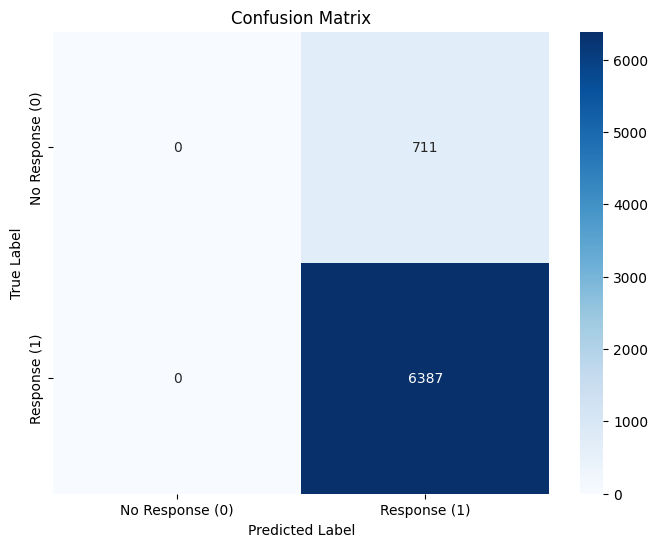

In [ ]:
#Confusion Matrix Visualization
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Create confusion matrix
cm = confusion_matrix(all_labels, all_predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Response (0)', 'Response (1)'],
            yticklabels=['No Response (0)', 'Response (1)'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

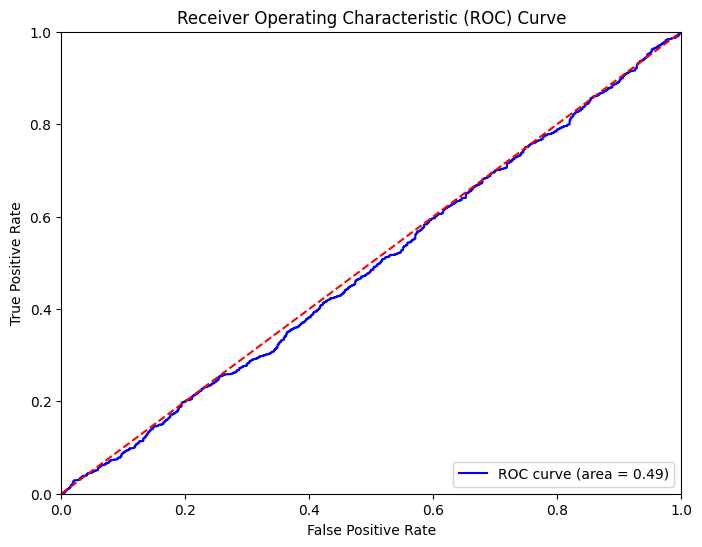

In [ ]:
# ROC Curve Visualization
from sklearn.metrics import roc_curve

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(all_labels, all_probs)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

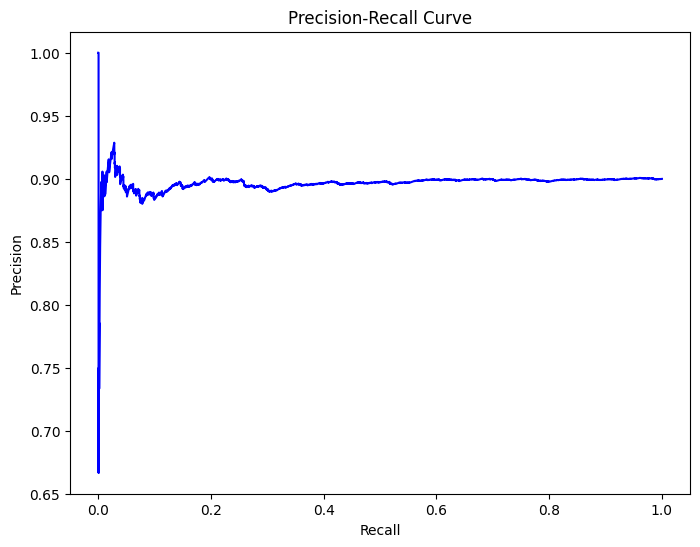

In [ ]:
#Precision-Recall Curve Visualization
from sklearn.metrics import precision_recall_curve

# Calculate Precision-Recall curve
precision, recall, thresholds = precision_recall_curve(all_labels, all_probs)

# Plot Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()